# GRF - examples 3D

Generate gaussian random fields (GRF) using fast Fourier transform (FFT).

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import from package 'geone'
from geone import grf
import geone.covModel as gcm
import geone.customcolors as ccol

## Define a covariance model

A covariance model is defined by its elementary contributions given as a list of 2-tuples, 
whose the first component is the type given by a string (`nugget`, `spherical`, `exponential`, `gaussian`, ...) and the second component is a dictionary used to pass the required parameters (the weight (`w`), the range (`r`), ...).  
Azimuth (`alpha`), dip (`beta`) and plunge (`gamma`) angles can be specified in degrees: the coordinates system Ox'''y''''z''', supporting the axes of the model (ranges), is obtained from the original coordinates system Oxyz as follows:
    - Oxyz       -> rotation of angle -alpha around Oz   -> Ox'y'z'
    - Ox'y'z'    -> rotation of angle -beta  around Ox'  -> Ox''y''z''
    - Ox''y''z'' -> rotation of angle -gamma around Oy'' -> Ox'''y'''z'''

In [2]:
cov_model = gcm.CovModel3D(elem=[
    ('gaussian', {'w':8.5, 'r':[40, 20, 10]}), # elementary contribution
    ('nugget', {'w':0.5})                    # elementary contribution
    ], alpha=-30, beta=-45, gamma=20, name='model-3D example')

## Functions of the covariance model and the variogram model
Get the functions.

In [3]:
cov_fun = cov_model.func()
vario_fun = cov_model.vario_func()

Get the sill and the range along each axis in the coordinates system supporting the axes of the model.

In [4]:
w = cov_model.sill() # scalar
r = cov_model.r123() # vector (1d-array) of length 3

Plot the functions (slice orthogonal to each axis).

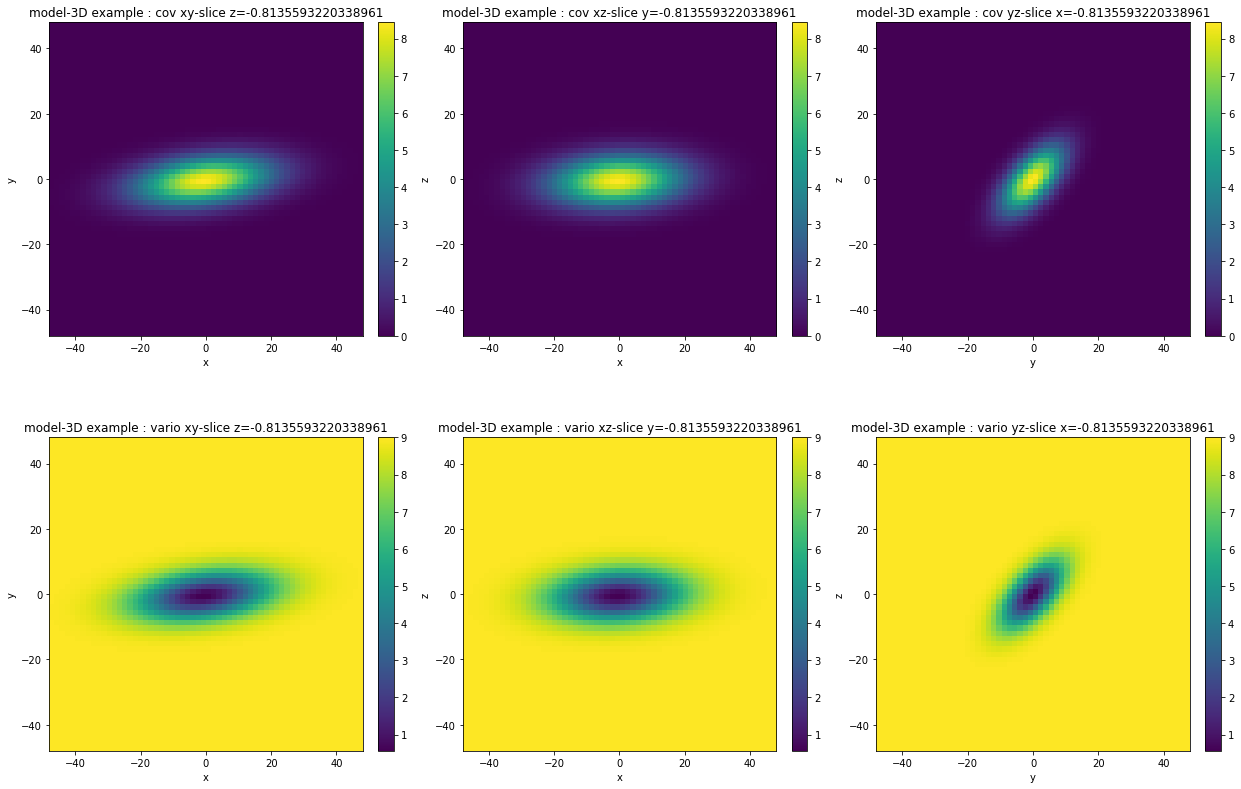

In [5]:
rmax = max(r)
mx, my, mz = 60, 60, 60
hx = np.linspace(-1.2*rmax, 1.2*rmax, mx)
hy = np.linspace(-1.2*rmax, 1.2*rmax, my)
hz = np.linspace(-1.2*rmax, 1.2*rmax, mz)

hhz, hhy, hhx = np.meshgrid(hz, hy, hx, indexing='ij')

hh = np.hstack((hhx.reshape(-1,1), hhy.reshape(-1,1), hhz.reshape(-1,1))) # 3D-lags: (n,3)-array
ch = cov_fun(hh).reshape(len(hz), len(hy), len(hx))
vh = vario_fun(hh).reshape(len(hz), len(hy), len(hx))

xmin, xmax = min(hx), max(hx)
ymin, ymax = min(hy), max(hy)
zmin, zmax = min(hz), max(hz)

ix0, iy0, iz0 = int((mx-1)/2), int((my-1)/2), int((mz-1)/2) # index of the 'middle' slice along each axis

plt.subplots(2,3,figsize=(21,14)) # plot with 6 sub-plots

# sub-plot 1-3: covariance model
plt.subplot(2,3,1)
im_plot = plt.imshow(ch[iz0,:,:], cmap='viridis', origin='lower', 
                     extent=[xmin,xmax,ymin,ymax],
                     interpolation='none')
plt.xlabel('x')
plt.ylabel('y')
plt.title('{} : cov xy-slice z={}'.format(cov_model.name, hz[iz0]))
ccol.add_colorbar(im_plot)

plt.subplot(2,3,2)
im_plot = plt.imshow(ch[:,iy0,:], cmap='viridis', origin='lower', 
                     extent=[xmin,xmax,zmin,zmax],
                     interpolation='none')
plt.xlabel('x')
plt.ylabel('z')
plt.title('{} : cov xz-slice y={}'.format(cov_model.name, hy[iy0]))
ccol.add_colorbar(im_plot)

plt.subplot(2,3,3)
im_plot = plt.imshow(ch[:,:,ix0], cmap='viridis', origin='lower', 
                     extent=[ymin,ymax,zmin,zmax],
                     interpolation='none')
plt.xlabel('y')
plt.ylabel('z')
plt.title('{} : cov yz-slice x={}'.format(cov_model.name, hx[ix0]))
ccol.add_colorbar(im_plot)

# sub-plot 4-6: variogram model
plt.subplot(2,3,4)
im_plot = plt.imshow(vh[iz0,:,:], cmap='viridis', origin='lower', 
                     extent=[xmin,xmax,ymin,ymax],
                     interpolation='none')
plt.xlabel('x')
plt.ylabel('y')
plt.title('{} : vario xy-slice z={}'.format(cov_model.name, hz[iz0]))
ccol.add_colorbar(im_plot)

plt.subplot(2,3,5)
im_plot = plt.imshow(vh[:,iy0,:], cmap='viridis', origin='lower', 
                     extent=[xmin,xmax,zmin,zmax],
                     interpolation='none')
plt.xlabel('x')
plt.ylabel('z')
plt.title('{} : vario xz-slice y={}'.format(cov_model.name, hy[iy0]))
ccol.add_colorbar(im_plot)

plt.subplot(2,3,6)
im_plot = plt.imshow(vh[:,:,ix0], cmap='viridis', origin='lower', 
                     extent=[ymin,ymax,zmin,zmax],
                     interpolation='none')
plt.xlabel('y')
plt.ylabel('z')
plt.title('{} : vario yz-slice x={}'.format(cov_model.name, hx[ix0]))
ccol.add_colorbar(im_plot)

## Simulation of GRF's - 3D
Define the simulation grid.

In [6]:
nx, ny, nz = 85, 56, 34  # number of cells
dx, dy, dz = 1.0, 1.0, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

dimension = [nx, ny, nz]
spacing = [dx, dy, dz]
origin = [ox, oy, oz]

As the generation of GRF's is based on FFT, periodic fields are generated. Hence, an extended simulation grid is used and then cropped after the simulation. The extension should be large enough in order to avoid wrong correlations, i.e. correlations across opposite borders of the grid, or correlations between two nodes regarding both distances between them (with respect to the periodic grid). This extension can be computed with the function `grf.extension_min`.

In [7]:
extensionMin = [grf.extension_min(r, n, s) for r, n, s in zip(cov_model.rxyz(), dimension, spacing)]

### Unconditional simulations
Set the number of realizations, the seed and launch the (unconditional) simulations.

In [8]:
nreal = 100
np.random.seed(123)
sim3Da = grf.grf3D(cov_fun, dimension, spacing, origin, 
                   extensionMin=extensionMin, nreal=nreal)

GRF3D: Preliminary computation...
GRF3D: Computing circulant embedding...
GRF3D: Embedding dimension: 128 x 128 x 64
GRF3D: Computing FFT of circulant matrix...
GRF3D: Unconditional simulation    1-   2 of  100...
GRF3D: Unconditional simulation    3-   4 of  100...
GRF3D: Unconditional simulation    5-   6 of  100...
GRF3D: Unconditional simulation    7-   8 of  100...
GRF3D: Unconditional simulation    9-  10 of  100...
GRF3D: Unconditional simulation   11-  12 of  100...
GRF3D: Unconditional simulation   13-  14 of  100...
GRF3D: Unconditional simulation   15-  16 of  100...
GRF3D: Unconditional simulation   17-  18 of  100...
GRF3D: Unconditional simulation   19-  20 of  100...
GRF3D: Unconditional simulation   21-  22 of  100...
GRF3D: Unconditional simulation   23-  24 of  100...
GRF3D: Unconditional simulation   25-  26 of  100...
GRF3D: Unconditional simulation   27-  28 of  100...
GRF3D: Unconditional simulation   29-  30 of  100...
GRF3D: Unconditional simulation   31-  32 of

The result is a 4d array of size `nreal` by `nz` by `ny` by `nx`:

In [9]:
sim3Da.shape

(100, 34, 56, 85)

Get the mean and the standard deviation.

In [10]:
sim3Da_mean = np.mean(sim3Da.reshape(nreal, -1), axis=0).reshape(nz, ny, nx)
sim3Da_std = np.std(sim3Da.reshape(nreal, -1), axis=0).reshape(nz, ny, nx)

Plot the first realizations, the mean, and the mean +/- standard deviation.

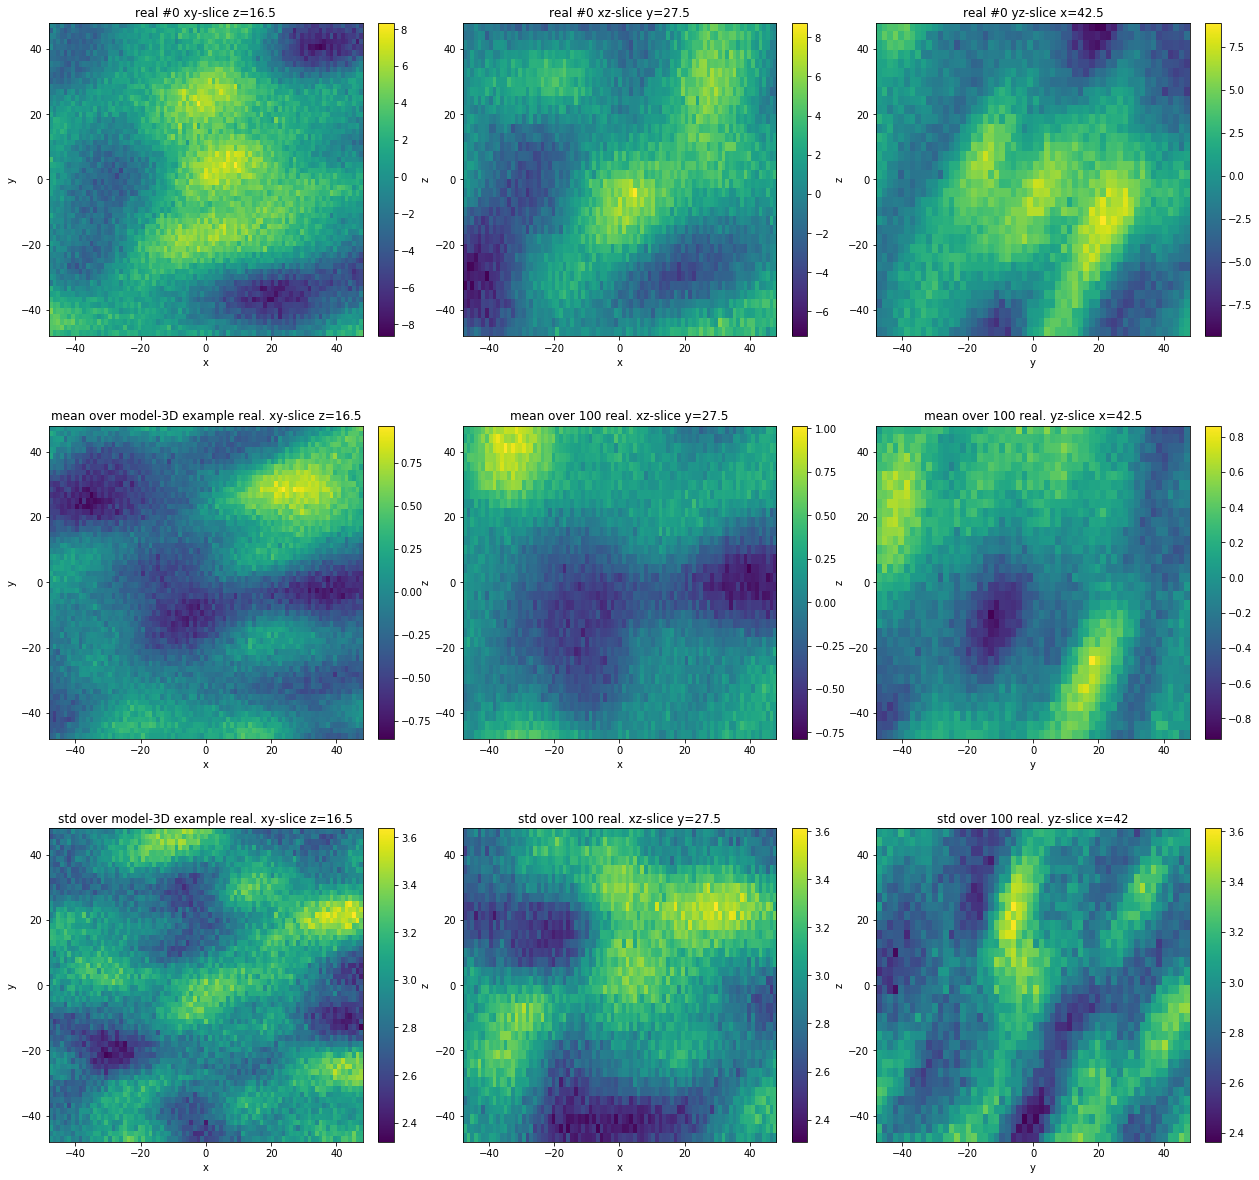

In [11]:
ix0, iy0, iz0 = int((nx-1)/2), int((ny-1)/2), int((nz-1)/2) # index of the 'middle' slice along each axis
x0 = ox + (ix0 + 0.5)*dx
y0 = oy + (iy0 + 0.5)*dy
z0 = oz + (iz0 + 0.5)*dz

plt.subplots(3,3,figsize=(21,21)) # plot with 3 sub-plots

# sub-plot 1-3: first real
plt.subplot(3,3,1)
im_plot = plt.imshow(sim3Da[0,iz0,:,:], cmap='viridis', origin='lower', 
                     extent=[xmin,xmax,ymin,ymax],
                     interpolation='none')
plt.xlabel('x')
plt.ylabel('y')
plt.title('real #0 xy-slice z={}'.format(z0))
ccol.add_colorbar(im_plot)

plt.subplot(3,3,2)
im_plot = plt.imshow(sim3Da[0,:,iy0,:], cmap='viridis', origin='lower', 
                     extent=[xmin,xmax,zmin,zmax],
                     interpolation='none')
plt.xlabel('x')
plt.ylabel('z')
plt.title('real #0 xz-slice y={}'.format(y0))
ccol.add_colorbar(im_plot)

plt.subplot(3,3,3)
im_plot = plt.imshow(sim3Da[0,:,:,ix0], cmap='viridis', origin='lower', 
                     extent=[ymin,ymax,zmin,zmax],
                     interpolation='none')
plt.xlabel('y')
plt.ylabel('z')
plt.title('real #0 yz-slice x={}'.format(x0))
ccol.add_colorbar(im_plot)

# sub-plot 4-6: mean
plt.subplot(3,3,4)
im_plot = plt.imshow(sim3Da_mean[iz0,:,:], cmap='viridis', origin='lower', 
                     extent=[xmin,xmax,ymin,ymax],
                     interpolation='none')
plt.xlabel('x')
plt.ylabel('y')
plt.title('mean over {} real. xy-slice z={}'.format(cov_model.name, z0))
ccol.add_colorbar(im_plot)

plt.subplot(3,3,5)
im_plot = plt.imshow(sim3Da_mean[:,iy0,:], cmap='viridis', origin='lower', 
                     extent=[xmin,xmax,zmin,zmax],
                     interpolation='none')
plt.xlabel('x')
plt.ylabel('z')
plt.title('mean over {} real. xz-slice y={}'.format(nreal, y0))
ccol.add_colorbar(im_plot)

plt.subplot(3,3,6)
im_plot = plt.imshow(sim3Da_mean[:,:,ix0], cmap='viridis', origin='lower', 
                     extent=[ymin,ymax,zmin,zmax],
                     interpolation='none')
plt.xlabel('y')
plt.ylabel('z')
plt.title('mean over {} real. yz-slice x={}'.format(nreal, x0))
ccol.add_colorbar(im_plot)

# sub-plot 7-9: standard deviation
plt.subplot(3,3,7)
im_plot = plt.imshow(sim3Da_std[iz0,:,:], cmap='viridis', origin='lower', 
                     extent=[xmin,xmax,ymin,ymax],
                     interpolation='none')
plt.xlabel('x')
plt.ylabel('y')
plt.title('std over {} real. xy-slice z={}'.format(cov_model.name, z0))
ccol.add_colorbar(im_plot)

plt.subplot(3,3,8)
im_plot = plt.imshow(sim3Da_std[:,iy0,:], cmap='viridis', origin='lower', 
                     extent=[xmin,xmax,zmin,zmax],
                     interpolation='none')
plt.xlabel('x')
plt.ylabel('z')
plt.title('std over {} real. xz-slice y={}'.format(nreal, y0))
ccol.add_colorbar(im_plot)

plt.subplot(3,3,9)
im_plot = plt.imshow(sim3Da_std[:,:,ix0], cmap='viridis', origin='lower', 
                     extent=[ymin,ymax,zmin,zmax],
                     interpolation='none')
plt.xlabel('y')
plt.ylabel('z')
plt.title('std over {} real. yz-slice x={}'.format(nreal, ix0))
ccol.add_colorbar(im_plot)

### Conditional simulations
Conditional simulations can be performed in 3D in a similar way as the 2D case (see the examples in 2D).

### Simulations with imposed mean and/or variance
Mean and variance in the simulation grid can be specified, they can be stationary (constant) or non-stationary. 
By default, the mean is zero (constant) and the variance is given by the sill of the variogram model (constant).

Such simulations can be performed in 3D in a similar way as the 2D case (see the examples in 2D).